# Building Binary Classification Model Using PyTorch

## 1. Import Libraries and Load the data:

In [1]:
# Data Manipulation libraries
import numpy as np
import pandas as pd
# Data Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
# Data Modeling libraries
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

### 1.1 loading the Breast Cancer dataset from sklearn.datasets:

In [2]:
# load the data
df = load_breast_cancer(as_frame=True)
target = df['target']
df = df['data']
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

In [4]:
target.head()

,target
0,0
1,0
2,0
3,0
4,0


In [5]:
target.value_counts()

,count
target,
1,357
0,212


### 1.2 splitting the dataset into training (70%), validation (15%), and test (15%) sets:

In [6]:
X_train, X_tmp, y_train, y_tmp = train_test_split(df, target, test_size=0.15, stratify=target, random_state=42)

In [7]:
X_val, X_test, y_val, y_test = train_test_split(X_tmp, y_tmp, test_size=0.18, stratify=y_tmp)

### 1.3 Normalize the numerical features:

In [8]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

### 1.4 Transorm to dataloader:

In [9]:
# Convert to PyTorch tensors
X_train_tensor = torch.tensor(np.array(X_train), dtype=torch.float32)
y_train_tensor = torch.tensor(np.array(y_train), dtype=torch.float32).view(-1, 1)
X_val_tensor = torch.tensor(np.array(X_val), dtype=torch.float32)
y_val_tensor = torch.tensor(np.array(y_val), dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(np.array(X_test), dtype=torch.float32)
y_test_tensor = torch.tensor(np.array(y_test), dtype=torch.float32).view(-1, 1)

In [10]:
# Create data loaders
train_dataset = data.TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = data.TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = data.TensorDataset(X_test_tensor, y_test_tensor)

train_loader = data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = data.DataLoader(val_dataset, batch_size=32)
test_loader = data.DataLoader(test_dataset, batch_size=32)

## 2. Model Building:

### 2.1 Define Model:

In [11]:
class NNModel(nn.Module):
  def __init__(self, input_size):
    super(NNModel, self).__init__()
    self.fc1 = nn.Linear(input_size, 64)
    self.fc2 = nn.Linear(64, 32)
    self.fc3 = nn.Linear(32, 1)
    self.relu = nn.ReLU()
    self.sigmoid = nn.Sigmoid()
  def forward(self, x):
    x = self.relu(self.fc1(x))
    x = self.relu(self.fc2(x))
    x = self.sigmoid(self.fc3(x))
    return x

In [12]:
model = NNModel(X_train.shape[1])

## 3. Training the Model:

### 3.1 Set the loss function and the optimizer:

In [13]:
loss_fn = nn.BCELoss()  # binary cross entropy
optimizer = optim.Adam(model.parameters(), lr=0.001)

### 3.2 Set the training loop:

In [14]:
# Training loop
num_epochs = 100
train_losses, val_losses = [], []
# Adding early stoping due to overfiting
patience = 5  # Number of epochs to wait before stopping if no improvement
best_val_loss = float('inf')
stopping_counter = 0

In [15]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_losses.append(running_loss / len(train_loader))

    # Validation loss
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            val_loss += loss.item()
    val_losses.append(val_loss / len(val_loader))

    # Early stopping check
    if val_losses[-1] < best_val_loss:
        best_val_loss = val_losses[-1]
        stopping_counter = 0  # Reset counter
    else:
        stopping_counter += 1
        if stopping_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")


Epoch 10/100 - Train Loss: 0.0500, Val Loss: 0.0952
Early stopping triggered at epoch 13


We can see our model converge after 6 epochs only and stopped the learning in the 11th epoch because of the patience of 5.

### 3.3 training and validation loss curves:

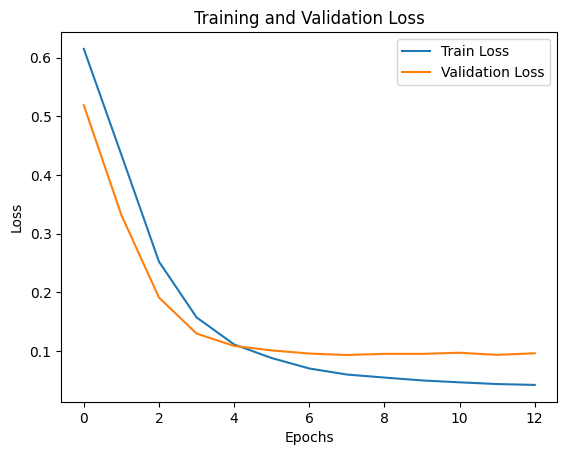

In [16]:
# Plot loss curves
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

## 4. Model Evaluation and Prediction:

In [17]:
# Model evaluation
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        predictions = (outputs >= 0.5).float()
        y_true.extend(labels.numpy().flatten())
        y_pred.extend(predictions.numpy().flatten())

In [18]:
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
print(f'Test Accuracy: {accuracy:.4f}')
print(f'F1 Score: {f1:.4f}')

Test Accuracy: 0.9375
F1 Score: 0.9474


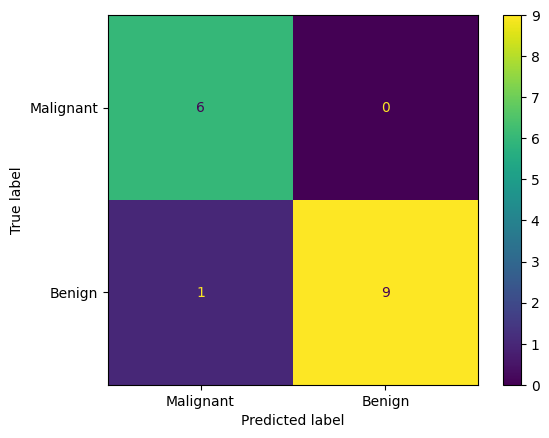

In [19]:
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Malignant", "Benign"])
disp.plot()
plt.show()

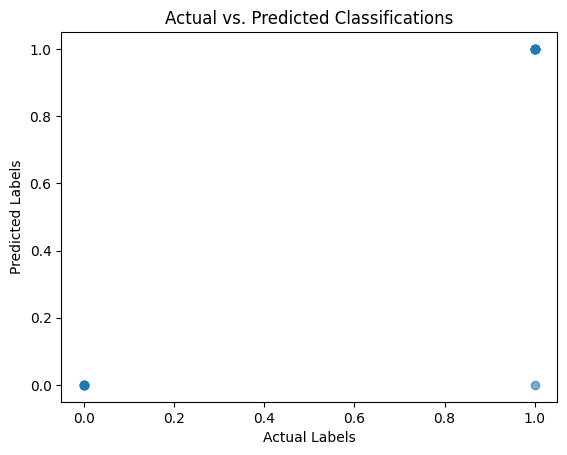

In [20]:
# Scatter Plot
plt.scatter(y_true, y_pred, alpha=0.6)
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.title('Actual vs. Predicted Classifications')
plt.show()